# Missing Data Prediction
#### - The goal of this project is to create a deep learning network that predicts values for missing data.
#### - I will randomly remove values from the residual sugar column of the UCI machine learning repository wine data set, and attempt to use deep learning to predict these values
#### - This project was designed by Mike X Cohen for his Deep Understanding of Deep Learning Course.
#### - This is my unique solution to this project. Much of the code for this project has been adapted from this course.
#### - This is the link to the data I will be using: https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

In [204]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/var/folders/dw/n4jtvcxx0gl3p_mb684zhpq00000gn/T/ipykernel_28188/2969157509.py:23: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


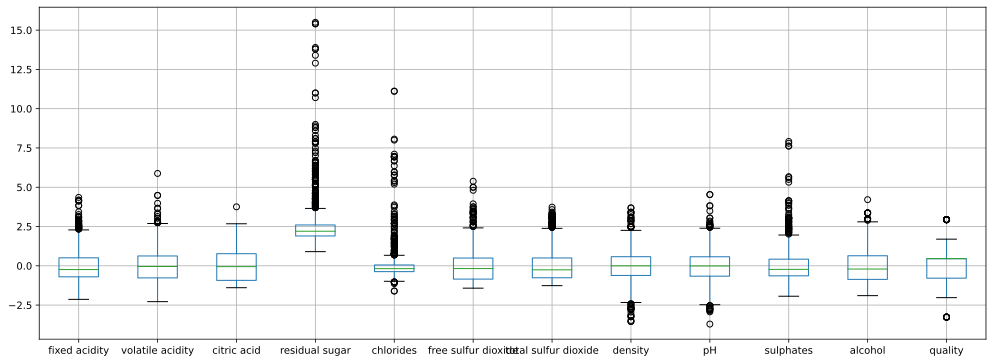

In [205]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for residual sugar
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('residual sugar')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

plt.figure(figsize = (17, 6))
data.boxplot()
plt.show()

In [206]:
# Now I will randomly remove 10 values from residual sugar column

data_mod = data.copy()
idx_to_remove = np.random.choice(1599, 10, replace = False) 

test_dataTMP = data_mod.loc[idx_to_remove] #create a new data frame to store our testing data

for row in idx_to_remove:
    data_mod.loc[row, "residual sugar"]=np.nan #replace the residual sugar value with nan, to practice having a data set with nans




In [207]:
data_mod_final = data_mod.dropna() 

#transform train and test data into tensors
train_data = torch.tensor( data_mod_final[cols2zscore].values ).float()
train_labels = torch.tensor( data_mod_final['residual sugar'].values ).float()
train_labels = train_labels[:,None] # transform to matrix

test_data = torch.tensor(test_dataTMP[cols2zscore].values ).float()
test_labels = torch.tensor(test_dataTMP['residual sugar'].values).float()

# Now convert to pytorch datasets

train_dataDataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# Now convert to Dataloaders
batchsize    = 32
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])



In [208]:
# create a class for the model
def createTheWineNet():
    
    class ANNwine(nn.Module):
        def __init__(self):
            super().__init__()
            
            ### input layer
            self.input = nn.Linear(11,32)
            
            ### hidden layers
            self.fc1 = nn.Linear(32,64)
            self.fc2 = nn.Linear(64,32)
            
            ### output layer
            self.output = nn.Linear(32,1)
      
        # forward pass
        def forward(self,x):
            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            x = F.relu( self.fc2(x) )
            return self.output(x) 

    # create the model instance
    net = ANNwine()

    #Loss fun and Optimizer
    lossfun = nn.MSELoss()
    optimizer = torch.optim.RMSprop(net.parameters(),lr=.01) 

    return net,lossfun,optimizer

In [209]:
#run some fake data to make sure it works properly
wnet,lossf,opt = createTheWineNet()
print(wnet)

# input is ten samples
input = torch.rand(10,11)
wnet(input)

ANNwine(
  (input): Linear(in_features=11, out_features=32, bias=True)
  (fc1): Linear(in_features=32, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


tensor([[0.0366],
        [0.0214],
        [0.0477],
        [0.0509],
        [0.0370],
        [0.0104],
        [0.0370],
        [0.0269],
        [0.0111],
        [0.0554]], grad_fn=<AddmmBackward0>)

In [210]:
# a function that trains the model

def trainTheModel():

    numepochs = 100
    
    #Create a new model
    winenet,lossfun,optimizer = createTheWineNet()

    # initialize losses
    trainLoss = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):
        
        # switch on training mode
        winenet.train()
        
        # loop over training data batches
        batchLoss = []
        
    
        for X,y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())
            # end of batch loop...

        # get average losses across the batches
        trainLoss[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
          yHat = winenet(X)
        testLoss[epochi] = lossfun(yHat,y).item()
  
    # function output
    return trainLoss,testLoss,winenet

In [211]:
# create a model and train it
trainLoss,testLoss,winenet = trainTheModel()

/Users/benjaminmellin/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


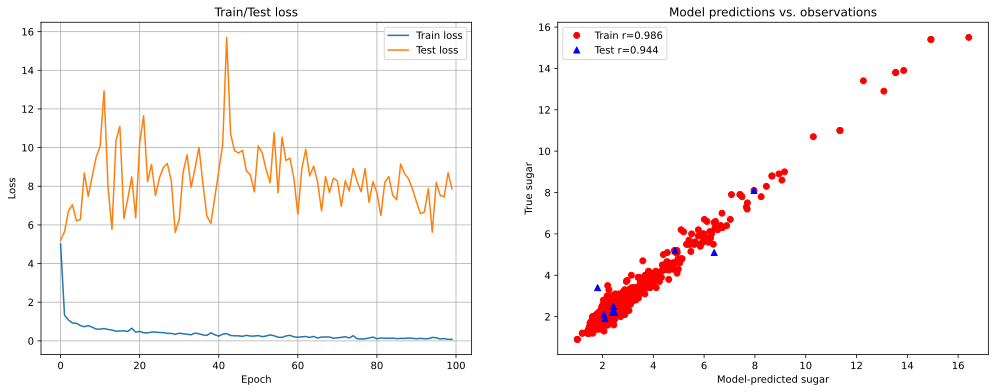

In [212]:
# plot some results
# This plotting code was adapted from Mike X Cohen's Code Challenge: Predict Sugar in his A Deep Understanding of Deep Learning Course

fig,ax = plt.subplots(1,2,figsize=(17,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = winenet(train_data)
yHatTest  = winenet(test_data)

ax[1].plot(yHatTrain.detach(),train_labels,'ro')
ax[1].plot(yHatTest.detach(),test_labels,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labels.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()